# UK Road Safety: Traffic Accidents and Vehicles - Data Exploration
## Detailed dataset of road accidents and involved vehicles in the UK (2005-2016)
Source:
<U>https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles#Accident_Information.csv</U>

# Load file into a Spark session from Object Store
One large CSV file <br>
Allow for loading a sample for intial exploration

In [1]:
# The code was removed by Watson Studio for sharing.

Row(Accident_Index='200501BS00001', 1st_Road_Class='A', 1st_Road_Number='3218', 2nd_Road_Class='NA', 2nd_Road_Number='0', Accident_Severity='Serious', Carriageway_Hazards='None', Date='2005-01-04', Day_of_Week='Tuesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Data missing or out of range', Junction_Detail='Not at junction or within 20 metres', Latitude='51.489096', Light_Conditions='Daylight', Local_Authority_(District)='Kensington and Chelsea', Local_Authority_(Highway)='Kensington and Chelsea', Location_Easting_OSGR='525680', Location_Northing_OSGR='178240', Longitude='-0.19117', LSOA_of_Accident_Location='E01002849', Number_of_Casualties='1', Number_of_Vehicles='1', Pedestrian_Crossing-Human_Control='0', Pedestrian_Crossing-Physical_Facilities='1', Police_Force='Metropolitan Police', Road_Surface_Conditions='Wet or damp', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit='30', Time='17:42', Urban_or_Rural_Area='Urban', Weather

In [2]:
def load_rdd_from_csv(spark=spark, fname='accidents.csv'):
    url = project.get_file_url(fname)
    return spark.read\
      .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
      .option('header', 'true')\
      .load(url)

def load_rdd_from_parquet(spark=spark, fname='accidents.parquet'):
    return spark.read.format("parquet").load(fname)

# Standard imports
+useful figure save function

In [3]:
import random as rnd
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')
#cmap=plt.get_cmap('tab20c')

mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  mypath_[0]+'/img/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close() 
    

# Create SQL view
* Rename some columns without special characters
* Cast some columns to appropriate types (from string to int or double)
* Create an additional "Hour" column from the "Time" field

1.9mios records and 35 fields: most are categorical

In [4]:
#rename columns with special characters
rdd_accidents = rdd_accidents.withColumnRenamed("Local_Authority_(District)", "Local_Authority_District")\
    .withColumnRenamed("Local_Authority_(Highway)", "Local_Authority_Highway")\
    .withColumnRenamed("Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing_Human_Control")\
    .withColumnRenamed("Pedestrian_Crossing-Physical_Facilities", "Pedestrian_Crossing_Physical_Facilities")
#create Hour column
rdd_accidents = rdd_accidents.withColumn("Hour", rdd_accidents["Time"].substr(0, 2).cast("int"))
#type convesions
rdd_accidents = rdd_accidents.withColumn("Latitude", rdd_accidents["Latitude"].cast("double"))
rdd_accidents = rdd_accidents.withColumn("Longitude", rdd_accidents["Longitude"].cast("double"))
rdd_accidents = rdd_accidents.withColumn("Location_Northing_OSGR", rdd_accidents["Location_Northing_OSGR"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Location_Easting_OSGR", rdd_accidents["Location_Easting_OSGR"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Number_of_Casualties", rdd_accidents["Number_of_Casualties"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Number_of_Vehicles", rdd_accidents["Number_of_Vehicles"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Speed_limit", rdd_accidents["Speed_limit"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Year", rdd_accidents["Year"].cast("int"))
rdd_accidents.take(1)

rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))

#Save as parquet files
rdd_accidents.write.format("parquet").mode("overwrite").save("accidents.parquet")



root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-- Num

In [17]:
#Select subset of the data

######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################


# Display categorical features
Categorical columns split into 5 groups

In [18]:
cat_cols1=[    
 'Accident_Severity',
 'Speed_limit',
 'Day_of_Week',
 'Urban_or_Rural_Area']
cat_cols2=[    
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Light_Conditions',
 'Special_Conditions_at_Site']
cat_cols3=[
 '1st_Road_Class',
 '2nd_Road_Class',
 'Road_Type',
 'Carriageway_Hazards']
cat_cols4=[    
 'Junction_Control',
 'Junction_Detail',
 'Pedestrian_Crossing_Human_Control',
 'Pedestrian_Crossing_Physical_Facilities']
cat_cols5=[    
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'InScotland']


def plot_cat_feature(df_view, col, ax=None, bar_color=cmap(1)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT 
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight, 
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe 
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(col, severe_col, acc_type, col, severe_col, acc_type, col, df_view, col))
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[col])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(col, kind='barh', ax=ax, fontsize=13, title=col.replace('_', ' '), 
                   color=clrmap, stacked=True, legend =(False if col==severe_col else True))
    ax.yaxis.grid(False)
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)): 
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (total, idx-ax.patches[0].get_height()/2), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    ax.legend(labels=['slight', 'severe (%)'])
    left, right = ax.get_xlim()  # return the current xlim
    ax.set_xlim((left, right*1.2))   
    xticks = ax.xaxis.get_ticklabels()
    every_nth = round(len(xticks)/3)
    for n, label in enumerate(xticks):
        if n % every_nth != 0:
            label.set_visible(False)
    return rdd_col



def plot_cat_cols(df_view, cat_cols, fname='', bar_color=cmap(1)):
    ncols = 2
    nrows = int(len(cat_cols)/ncols) + (1 if len(cat_cols)%ncols !=0 else 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*7, nrows*4))
    for n, col in enumerate(cat_cols):
        ax = axes[n] if nrows==1 else axes[int(n/ncols), n % ncols]
        plot_cat_feature(df_view, col, ax=ax, bar_color=bar_color)
        #axes[int(n/ncols), n % ncols].plot([0,1,2,3,4,5], [0,1,4,9,16,25])
    for n in range(len(cat_cols), ncols*nrows):
        fig.delaxes(axes[int(n/ncols), n % ncols])
    plt.subplots_adjust(wspace = 1.5, left=0, hspace=0.3)#bottom=0.1, right=0.8, top=0.9)
    if fname !='':
        save_fig(fig, fname,  tight_layout=False)

## Accident_Severity, Speed_Limit, Day_of_Week and  Urban_or_Rural_Area
* <b>Most accidents occur at low speed limits but they are more severe in proportion at higher speed limits (makes sense)</b><br>
* <b>Weekends see less accidents than weekdays but they are more severe </b>

Saving figure Figure(1008x576)


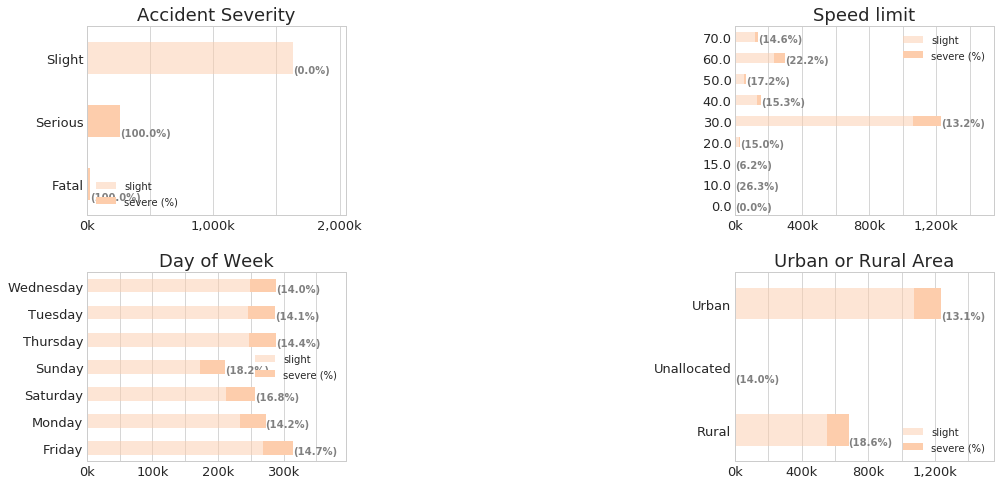

In [17]:
plot_cat_cols('accidents', cat_cols1, fname='cat1_eda', bar_color=cmap(1))

## Weather, road surface and light conditions
* <b>Most accidents occur in normal weather, only Fog or High winds increase the proportion of severe accidents</b><br>
* <b>Darkness significantly increase the probability of severe accidents</b><br>
* <b>Bad Road surface conditions do not increase accident severity</b>

Saving figure Figure(1008x576)


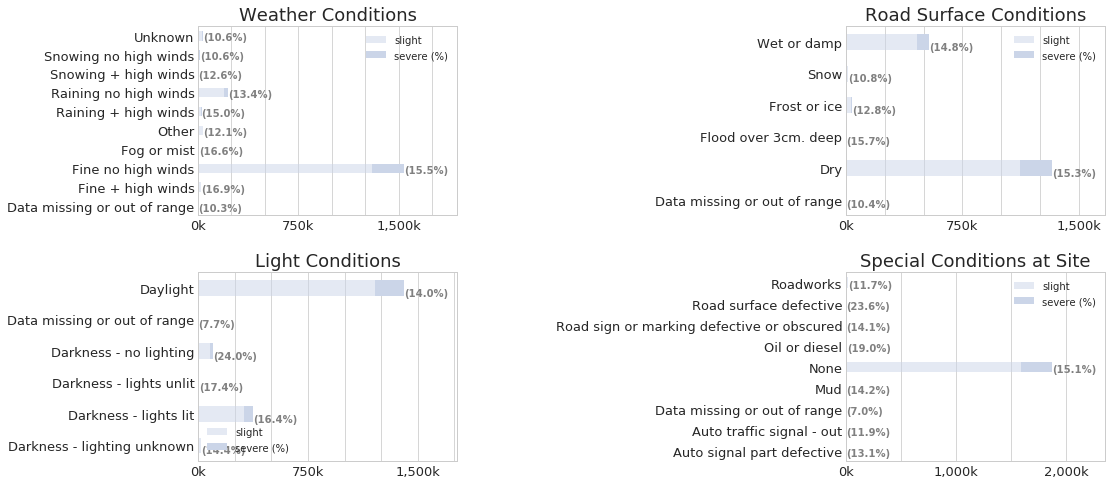

In [19]:
plot_cat_cols('accidents', cat_cols2, fname='cat2_eda', bar_color=cmap(2))

## Road Types and Class
* <b>The majority of accidents occur in single carriage A class roads<br></b>


Saving figure Figure(1008x576)


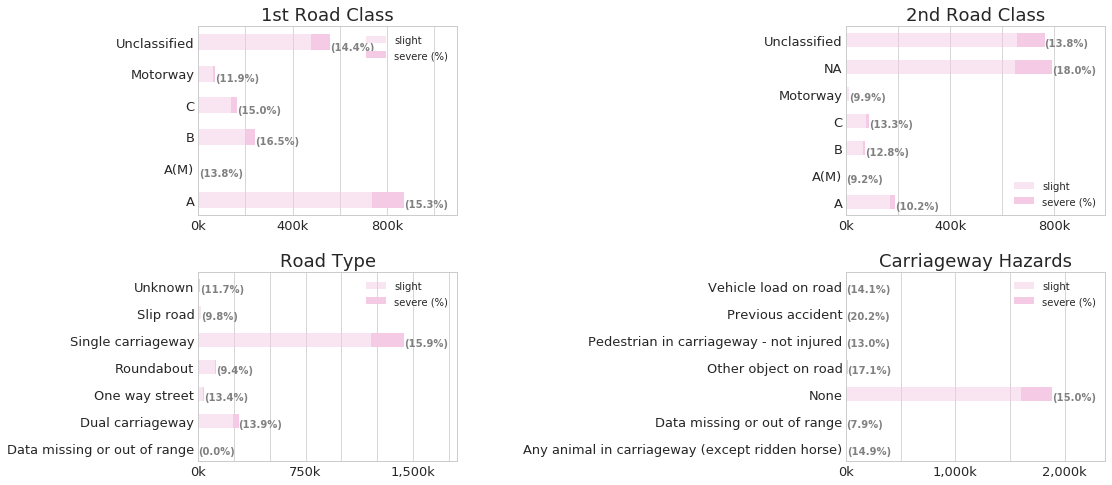

In [20]:
plot_cat_cols('accidents', cat_cols3, fname='cat3_eda', bar_color=cmap(3))


## Junctions types
* <b>The majority of accidents occur away from a junction</b><br>
* <b>Also the presence of a junction do not increase accident severity</b>

Saving figure Figure(1008x576)


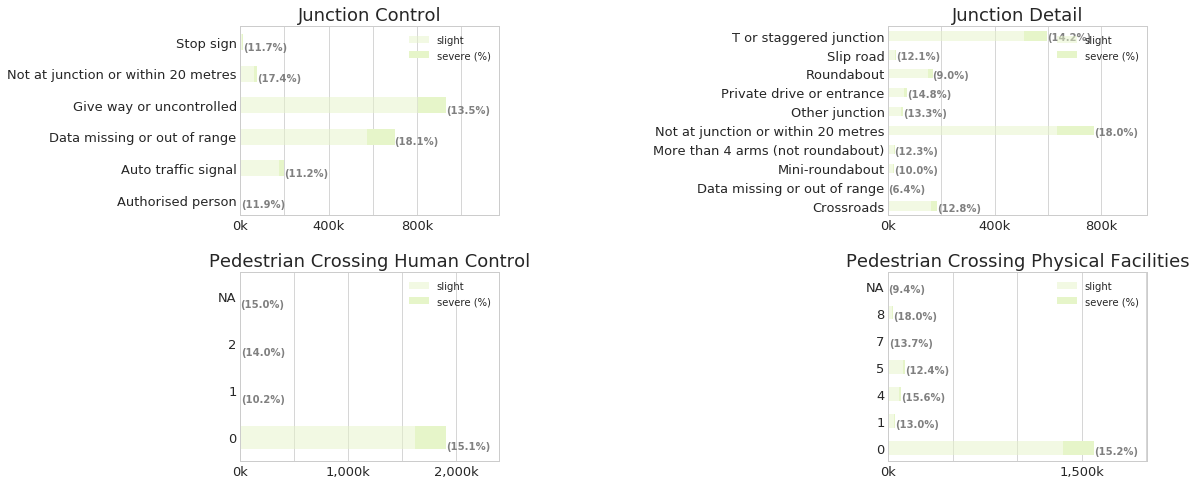

In [21]:
plot_cat_cols('accidents', cat_cols4, fname='cat4_eda', bar_color=cmap(4))

Saving figure Figure(1008x288)


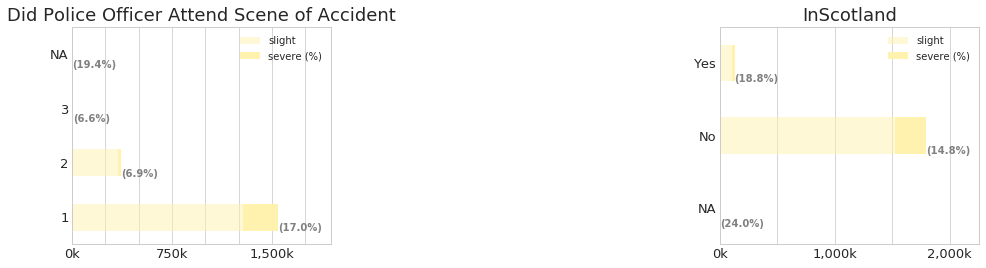

In [22]:
plot_cat_cols('accidents', cat_cols5, fname='cat5_eda', bar_color=cmap(5))

# Display ordinal features

In [23]:
#type conversions
ord_cols=["Hour",
           "Number_of_Casualties",
           "Number_of_Vehicles",
           "Year",]

def plot_ord_feature_old(df_view, col, ax=None, bar_color=cmap(6)):
    rdd_col = spark.sql("SELECT {}, COUNT({}) AS count FROM {} GROUP BY {}".format(col, col, df_view, col))
    df_plot = rdd_col.toPandas().sort_values(by=[col])
    ax = df_plot.plot(col, kind='bar', legend=False, ax=ax, fontsize=13, title=col.replace('_', ' '), 
                      color=bar_color, edgecolor='black')
    #ax = plt.gca()
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.title.set_size(18)
    totals = []
    for i in ax.patches:         
        totals.append(i.get_width())
    total = sum(totals)
    for patch in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
        patch.set_edgecolor("black")
        #ax.text(patch.get_width()*1.0, patch.get_y()*1.04, str(round((patch.get_width()/total)*100, 1))+'%', 
        #        fontsize=10, color='grey', fontweight='bold')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(x)))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    left, right = ax.get_xlim()  # return the current xlim
    ax.set_xlim((left, right*1.2))    
    return rdd_col


def plot_ord_feature(df_view, col, ax=None, bar_color=cmap(6)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT 
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight, 
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe 
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(col, severe_col, acc_type, col,severe_col, acc_type, col, df_view, col))
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[col])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(col, kind='bar', ax=ax, fontsize=13, title=col.replace('_', ' '), 
                      color=clrmap, stacked=True)
    #ax = plt.gca()
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.xaxis.grid(False)
    ax.set_xticklabels(df_plot[col])
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)): 
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (idx, total), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold', rotation=90, va ='bottom')

    #ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(x)))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    left, right = ax.get_ylim()  # return the current xlim
    ax.set_ylim((left, right*1.4))    
    return rdd_col


def plot_ord_cols(df_view, cont_cols, fname='ord_eda',bar_color=cmap(6)):
    ncols = 2
    nrows = int(len(cont_cols)/ncols) + (1 if len(cont_cols)%ncols !=0 else 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*7, nrows*4))
    for n, col in enumerate(cont_cols):
        plot_ord_feature(df_view, col, ax=axes[int(n/ncols), n % ncols], bar_color=bar_color)
    for n in range(len(cont_cols), ncols*nrows):
        fig.delaxes(axes[int(n/ncols), n % ncols])
    plt.subplots_adjust(wspace =0.2, left=0, hspace=0.5)#bottom=0.1, right=0.8, top=0.9)
    if fname != '':
        save_fig(fig, fname,  tight_layout=False)
        

## Other Features
* <b>Day times and peak times experience the most accidents but they are more severe at night</b><br>
* <b>Over the years the trend has been towards a reduction in the numner of accidents but an increase in severity</b>

Saving figure Figure(1008x576)


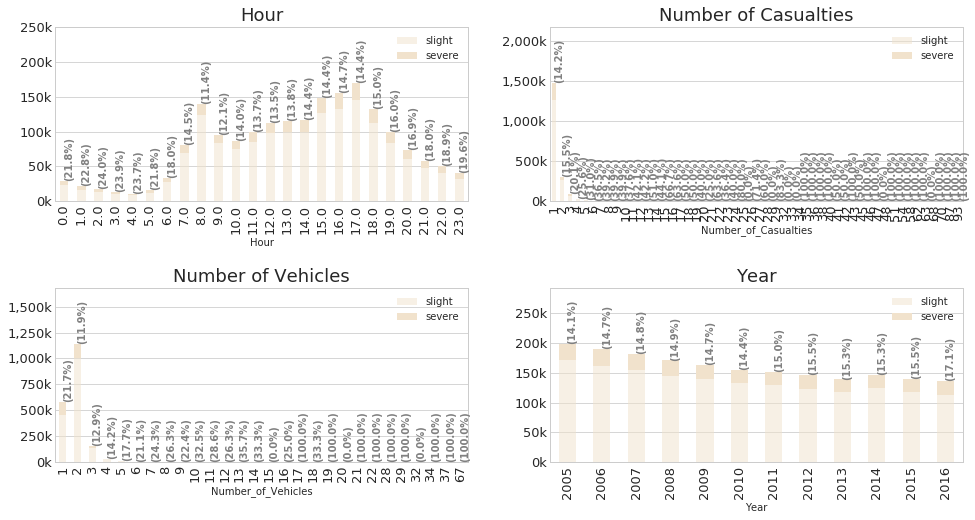

In [260]:
plot_ord_cols("accidents", ord_cols, fname='ord_eda')


In [41]:
plt.get_cmap('Reds')(100)

(0.40392156862745099, 0.0, 0.050980392156862737, 1.0)

Saving figure Figure(504x360)


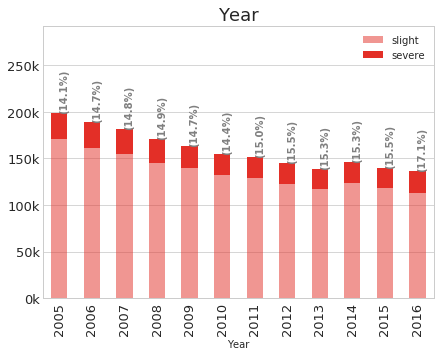

In [46]:
fig, ax =plt.subplots(figsize=(7,5))
plot_ord_feature("accidents", 'Year', ax=ax, bar_color=plt.get_cmap('Reds')(170))
save_fig(fig, 'accidents_per_year',  tight_layout=False)

# Geospatial visualisations
Every record is a geospatial datum since it contains spatial localisation (long/lat, OS National Grid References or Output areas)

In [ ]:
#install folium to display and save interactive maps
import pip
pip.main(['install', 'folium'])
pip.main(['install', 'geopandas'])
pip.main(['install', 'descartes'])
pip.main(['install', 'selenium'])


In [91]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

colormap_colors = ['blue', 'yellow', 'red']
s_rng = [-1,1]
colormap = cm.LinearColormap(colormap_colors, vmin=s_rng[0], vmax=s_rng[1]).to_step(100)

geo_cols=["Local_Authority_District",
          "Local_Authority_Highway",
          "Latitude",
          "Longitude",
          "Location_Easting_OSGR",
          "Location_Northing_OSGR",
          "LSOA_of_Accident_Location"] 

def plot_map(df_view, col, criteria, field, max_samples=10000, min_opacity=0.1):
    df = spark.sql("SELECT latitude, longitude, {} FROM {} WHERE {} = {} ".format(field, df_view, col, "'"+criteria+"'"))\
    .toPandas().dropna().sample(max_samples)
    folium_map = folium.Map(location=[54.197496,-3.886918],
                        zoom_start=6, tiles="Mapbox Bright")
    max_amount = df[field].max()
    gradient = {0: colormap_colors[0], 0.5: colormap_colors[1], 1.0: colormap_colors[2]}
    heat_map = HeatMap( list(zip(df.latitude.values,df.longitude.values,df[field].values)),
                min_opacity=min_opacity, max_val=max_amount, radius=5, blur=5, 
                max_zoom=1, gradient=gradient)
    return folium_map.add_child(heat_map)

In [11]:
#Plot heatmap of severe accidents
plot_map("accidents", "Accident_Severity", 'Serious', 'Number_of_Casualties')

<b> Severe accidents appear to be more spatially correlated</b>

In [12]:
#Plot heatmap of slight accidents
plot_map("accidents", "Accident_Severity", 'Slight', 'Number_of_Casualties')

In [226]:
import collections
from collections import Counter

def conditional_entropy(x, y):
    """
    code from: https://github.com/shakedzy/dython/blob/master/dython/nominal.py
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas DataFrame
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas DataFrame
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theils_u(x, y):
    """
    code from: https://github.com/shakedzy/dython/blob/master/dython/nominal.py
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    :param x: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas DataFrame
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

    
def theils_u_rdd(col_x, col_y, df_view):
   sql_query= '''SELECT {} AS val FROM {}'''
    rdd_colx = spark.sql(sql_query.format(col_x, df_view)).toPandas().dropna()
    rdd_coly = spark.sql(sql_query.format(col_y, df_view)).toPandas().dropna()
    x=rdd_colx['val'].values
    y=rdd_coly['val'].values
    return theils_u(x,y), theils_u(y,x)


def calc_coeff_table(cols, df_view):
    nb_features = len(cols)    
    coeff_table = [[0 if i!=j else 1 for i in range(nb_features)] for j in range(nb_features)]
    total_calc = (nb_features-1)*(nb_features)/2
    nb_calc=0
    for i in range(1, nb_features):
        for j in range(i):
            nb_calc +=1
            print("#{} Feature1:'{}' Feature2:'{}'".format(nb_calc, cols[i], cols[j]))
            th_xy, th_yx = theils_u_rdd(cols[i], cols[j], df_view)
            print("{:0.1f}% completed - th_xy={:0.2f} th_yx={:0.2f}".format(100*nb_calc/total_calc, th_xy, th_yx))
            coeff_table[i][j] = th_xy
            coeff_table[j][i] = th_yx
    return coeff_table
            

In [229]:
cols = cat_cols1+cat_cols2+cat_cols3+cat_cols4+cat_cols5+ord_cols
start_time = time.time()
coeff_table = calc_coeff_table(cols, "accidents")
print("Uncertainty Coefficient Table Computed  - Processing time: {:0.0f} secs".format(time.time() - start_time))


#1 Feature1:'Speed_limit' Feature2:'Accident_Severity'
0.4% completed - th_xy=0.00 th_yx=0.01
#2 Feature1:'Day_of_Week' Feature2:'Accident_Severity'
0.9% completed - th_xy=0.00 th_yx=0.00
#3 Feature1:'Day_of_Week' Feature2:'Speed_limit'
1.3% completed - th_xy=0.00 th_yx=0.00
#4 Feature1:'Urban_or_Rural_Area' Feature2:'Accident_Severity'
1.7% completed - th_xy=0.01 th_yx=0.01
#5 Feature1:'Urban_or_Rural_Area' Feature2:'Speed_limit'
2.2% completed - th_xy=0.36 th_yx=0.21
#6 Feature1:'Urban_or_Rural_Area' Feature2:'Day_of_Week'
2.6% completed - th_xy=0.00 th_yx=0.00
#7 Feature1:'Weather_Conditions' Feature2:'Accident_Severity'
3.0% completed - th_xy=0.00 th_yx=0.00
#8 Feature1:'Weather_Conditions' Feature2:'Speed_limit'
3.5% completed - th_xy=0.01 th_yx=0.00
#9 Feature1:'Weather_Conditions' Feature2:'Day_of_Week'
3.9% completed - th_xy=0.00 th_yx=0.00
#10 Feature1:'Weather_Conditions' Feature2:'Urban_or_Rural_Area'
4.3% completed - th_xy=0.00 th_yx=0.01
#11 Feature1:'Road_Surface_Conditio

<b>Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.</b><br>
<b>This is the uncertainty of x given y: value is on the range of [0,1]</b> <br>
<b>where 0 means y provides no information about x, </b><br>
<b>and 1 means y provides full information about x.</b><br>
<b>This is an asymmetric coefficient: U(x,y) != U(y,x)</b><br>
<b>Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient</b>

Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] 
    where 0 means y provides no information about x, 
    and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient


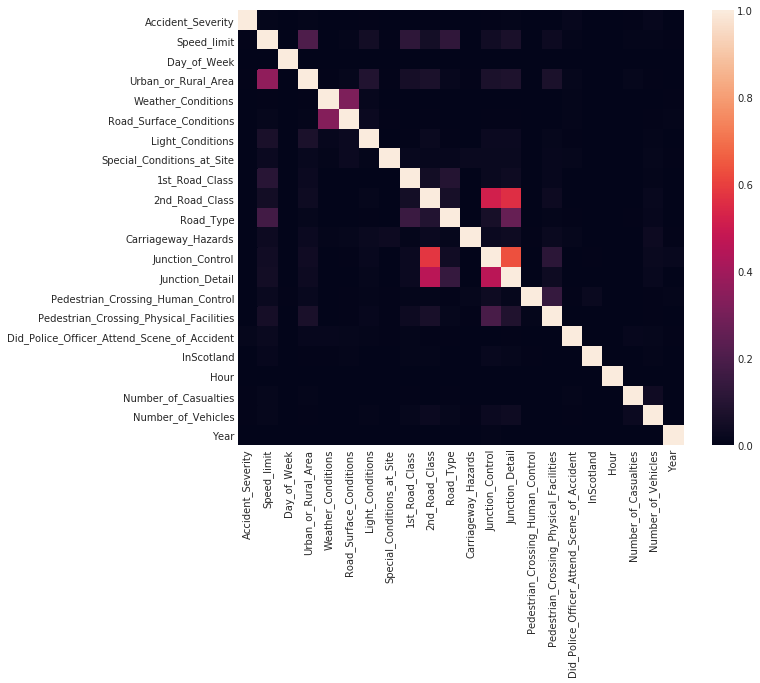

In [233]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(coeff_table, xticklabels=cols, yticklabels=cols, ax=ax, vmin=0, vmax=1)


## Categorical-categorical associations (above)
* <b>All categorical features have low associations: by themselves they do not bring strong explanatory power to each other</b>
* <b>Only 2nd road class and Junction Details/Control show some associations</b>
* <b>It is important to note that those are binary (one-to-one) associations: there could be more meaningful associations revealed by a suitable model</b>

In [234]:
cols = ['Accident_Severity'] + geo_cols
start_time = time.time()
coeff_table2 = calc_coeff_table(cols, "accidents")
print("Uncertainty Coefficient Table Computed  - Processing time: {:0.0f} secs".format(time.time() - start_time))


#1 Feature1:'Local_Authority_District' Feature2:'Accident_Severity'
3.6% completed - th_xy=0.00 th_yx=0.01
#2 Feature1:'Local_Authority_Highway' Feature2:'Accident_Severity'
7.1% completed - th_xy=0.00 th_yx=0.01
#3 Feature1:'Local_Authority_Highway' Feature2:'Local_Authority_District'
10.7% completed - th_xy=1.00 th_yx=0.86
#4 Feature1:'Latitude' Feature2:'Accident_Severity'
14.3% completed - th_xy=0.02 th_yx=0.73
#5 Feature1:'Latitude' Feature2:'Local_Authority_District'
17.9% completed - th_xy=0.39 th_yx=0.93
#6 Feature1:'Latitude' Feature2:'Local_Authority_Highway'
21.4% completed - th_xy=0.34 th_yx=0.93
#7 Feature1:'Longitude' Feature2:'Accident_Severity'
25.0% completed - th_xy=0.03 th_yx=0.76
#8 Feature1:'Longitude' Feature2:'Local_Authority_District'
28.6% completed - th_xy=0.39 th_yx=0.94
#9 Feature1:'Longitude' Feature2:'Local_Authority_Highway'
32.1% completed - th_xy=0.34 th_yx=0.94
#10 Feature1:'Longitude' Feature2:'Latitude'
35.7% completed - th_xy=0.96 th_yx=0.96
#11 Fea

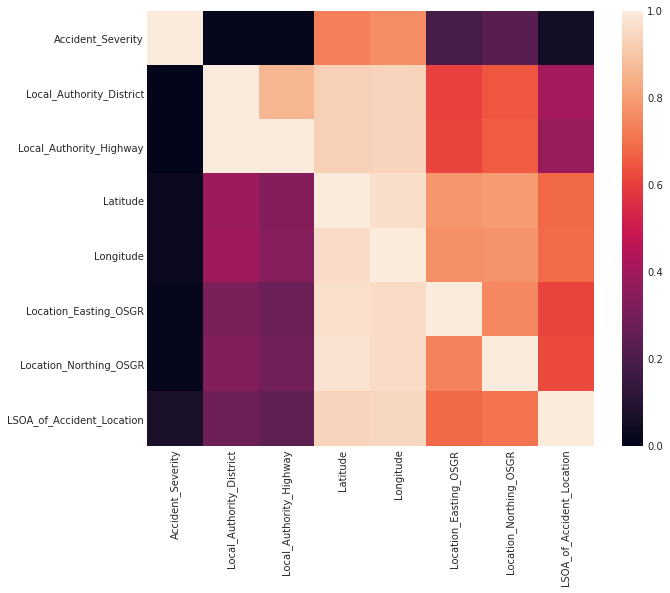

In [236]:
fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(coeff_table2, xticklabels=cols, yticklabels=cols, ax=ax, vmin=0, vmax=1)


## Accident_Severity-GeoSpatial associations analysis
* <b>As seen on the Geospatial visualisations, there is some asociation between localisation and accident severity.</b><br>
* <b>Specifically, given a certain accident_severity, determining  lat/lon is possible.</b><br>
* <b>The reverse is not true though: It seems difficult to predict accident severity given a certain location</b>

In [120]:
# categorical correlation calculation based on conditional entropy
# Also called Uncertainty coefficient or  Theil's U
# this calculation is not symetric, allowing to determine the predictive power of one variable to another
# inspired from https://github.com/shakedzy/dython/blob/master/dython/nominal.py

import math
import scipy.stats as ss


def conditional_entropy(col_x, col_y, df_view):
    #Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    #:param colx: dataframe col
    #:param coly: dataframe col 
    #:return: float
    sql_query= '''SELECT {}, COUNT({}) AS count_y FROM {} GROUP BY {}'''
    rdd_coly = spark.sql(sql_query.format(col_y, col_y, df_view, col_y)).toPandas().dropna().sort_values(by=[col_y])
    sql_query = '''SELECT {}, {} FROM {} '''
    rdd_col = spark.sql(sql_query.format(col_x, col_y, df_view))
    rdd_colxy = rdd_col.crosstab(col_x,col_y).toPandas().dropna().sort_values(by=[col_x+'_'+col_y])
    # entropy of x given y
    total_occurrences = rdd_coly['count_y'].sum()
    entropy = 0.0
    for xy in rdd_colxy[col_x+'_'+col_y].values:
        for y in rdd_coly[col_y]:
            y_str = y if isinstance(y, str) else '{:0.0f}'.format(y)
            p_xy = rdd_colxy[rdd_colxy[col_x+'_'+col_y]==xy][y_str].values[0] / total_occurrences
            p_y = rdd_coly[rdd_coly[col_y]==y].count_y.values[0] / total_occurrences
        entropy += 0 if p_xy==0 else p_xy * math.log(p_y/p_xy)
    return entropy


def theils_u(col_x, col_y, df_view):
    #Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    #This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    #x, and 1 means y provides full information about x.
    #This is an asymmetric coefficient: U(x,y) != U(y,x)
    #Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    #:param colx: dataframe col
    #:param coly: dataframe col 
    #:return: float in the range of [0,1]
    s_xy = conditional_entropy(col_x, col_y, df_view)
    sql_query= '''SELECT {}, COUNT({}) AS count_x FROM {} GROUP BY {}'''
    rdd_colx = spark.sql(sql_query.format(col_x, col_x, df_view, col_x)).toPandas().dropna().sort_values(by=[col_x])
    total_occurrences = rdd_colx['count_x'].sum()
    p_x = list(map(lambda n: n/total_occurrences, rdd_colx['count_x'].values))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
    
def theils_u_quick(col_x, col_y, df_view):
    #Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    #This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    #x, and 1 means y provides full information about x.
    #This is an asymmetric coefficient: U(x,y) != U(y,x)
    #Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    #:param colx: dataframe col
    #:param coly: dataframe col 
    #:return: float in the range of [0,1]
    sql_query= '''SELECT {}, COUNT({}) AS nb_rec FROM {} GROUP BY {}'''
    rdd_colx = spark.sql(sql_query.format(col_x, col_x, df_view, col_x)).toPandas().dropna().sort_values(by=[col_x])
    rdd_coly = spark.sql(sql_query.format(col_y, col_y, df_view, col_y)).toPandas().dropna().sort_values(by=[col_y])
    sql_query = '''SELECT {}, {} FROM {} '''
    rdd_col = spark.sql(sql_query.format(col_x, col_y, df_view))
    rdd_colxy = rdd_col.crosstab(col_x,col_y).toPandas().dropna().sort_values(by=[col_x+'_'+col_y])
    rdd_colyx = rdd_col.crosstab(col_y,col_x).toPandas().dropna().sort_values(by=[col_y+'_'+col_x])
    total_occurrencesx = rdd_colx['nb_rec'].sum()
    total_occurrencesy = rdd_coly['nb_rec'].sum()
    # entropy of x given y
    s_xy = 0.0
    for xy in rdd_colxy[col_x+'_'+col_y].values:
        for y in rdd_coly[col_y]:
            y_str = y if isinstance(y, str) else '{:0.0f}'.format(y)
            p_xy = rdd_colxy[rdd_colxy[col_x+'_'+col_y]==xy][y_str].values[0] / total_occurrencesy
            p_y = rdd_coly[rdd_coly[col_y]==y].nb_rec.values[0] / total_occurrencesy
        s_xy += 0 if p_xy==0 else p_xy * math.log(p_y/p_xy) 
    p_x = list(map(lambda n: n/total_occurrencesx, rdd_colx['nb_rec'].values))
    s_x = ss.entropy(p_x)
    th_xy =1 if s_x ==0  else (s_x - s_xy) / s_x
    # entropy of x given y
    s_yx = 0.0
    for yx in rdd_colyx[col_y+'_'+col_x].values:
        for x in rdd_colx[col_x]:
            x_str = x if isinstance(x, str) else '{:0.0f}'.format(x)
            p_yx = rdd_colyx[rdd_colyx[col_y+'_'+col_x]==yx][x_str].values[0] / total_occurrencesx
            p_x = rdd_colx[rdd_colx[col_x]==x].nb_rec.values[0] / total_occurrencesx
        s_yx += 0 if p_yx==0 else p_yx * math.log(p_x/p_yx)
    p_y = list(map(lambda n: n/total_occurrencesy, rdd_coly['nb_rec'].values))
    s_y = ss.entropy(p_y)
    th_yx =1 if s_y ==0  else (s_y - s_yx) / s_y
    print("x={} entropy={}".format(col_x, s_x))
    display(rdd_colx)
    print("y={} entropy={}".format(col_y, s_y))
    display(rdd_coly)
    print("xy={}".format(s_xy))
    display(rdd_colxy)
    print("yx={}".format(s_yx))
    display(rdd_colyx)
    return th_xy, th_yx



def calc_coeff_table(cols, df_view):
    nb_features = len(cols)    
    coeff_table = [[0 if i!=j else 1 for i in range(nb_features)] for j in range(nb_features)]
    total_calc = (nb_features-1)*(nb_features)/2
    nb_calc=0
    for i in range(1, nb_features):
        for j in range(i):
            nb_calc +=1
            print("#{} Feature1:'{}' Feature2:'{}'".format(nb_calc, cols[i], cols[j]))
            th_xy, th_yx = theils_u_quick(cols[i], cols[j], df_view)
            print("{:0.1f}% completed - th_xy={:0.2f} th_yx={:0.2f}".format(100*nb_calc/total_calc, th_xy, th_yx))
            coeff_table[i][j] = th_xy
            coeff_table[j][i] = th_yx
    return coeff_table
            